In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, Merge,                          BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valentin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
index_dataset = pd.read_csv("nasdaq.csv")
news_dataset = pd.read_csv("news.csv")
index_dataset.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,4837.180176,4880.169922,4837.169922,4862.569824,1745130000,4862.569824
1,2016-06-30,4793.750000,4843.109863,4774.520020,4842.669922,2171180000,4842.669922
2,2016-06-29,4732.930176,4787.589844,4732.339844,4779.250000,2116550000,4779.250000
3,2016-06-28,4643.930176,4692.979980,4643.930176,4691.870117,2074090000,4691.870117
4,2016-06-27,4664.430176,4665.040039,4574.250000,4594.439941,2659650000,4594.439941


In [77]:
index_dataset.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [78]:
news_dataset.isnull().sum()

Date    0
News    0
dtype: int64

In [79]:
news_dataset.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [80]:
print(index_dataset.shape)
print(news_dataset.shape)

(1989, 7)
(73608, 2)


In [81]:
#кол-во уникальных дат
print(len(set(index_dataset.Date)))
print(len(set(news_dataset.Date)))

1989
2943


In [82]:
#удаление лишних данных из новостей
news_dataset = news_dataset[news_dataset.Date.isin(index_dataset.Date)]
print(len(set(index_dataset.Date)))
print(len(set(news_dataset.Date)))

1989
1989


In [83]:
#разница в цене открытия между текуущим и прошлым днями
index_dataset = index_dataset.set_index('Date').diff(periods=1)
index_dataset['Date'] = index_dataset.index
index_dataset = index_dataset.reset_index(drop=True)
index_dataset = index_dataset.drop(['High','Low','Close','Volume','Adj Close'], 1)
index_dataset.head()

,Open,Date
0,NaN,2016-07-01
1,-43.430176,2016-06-30
2,-60.819824,2016-06-29
3,-89.000000,2016-06-28
4,20.500000,2016-06-27


In [84]:
#удаляем первую строку, т.к. null
index_dataset = index_dataset[index_dataset.Open.notnull()]

In [85]:
#проверка на null
index_dataset.isnull().sum()

Open    0
Date    0
dtype: int64

In [86]:
#создание списка цен и их соотношения с заголовками новостей
price = []
headlines = []
for row in index_dataset.iterrows():
    date = row[1]['Date']
    price.append(row[1]['Open'])
    daily_headlines = [row_[1]['News'] for row_ in news_dataset[news_dataset.Date == date].iterrows()]
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

500
1000
1500


In [87]:
#проверка
print(len(price))
print(len(headlines))

1988
1988


In [88]:
#макс и мин кол-во заголовков в день
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
# print(np.mean(len(i) for i in headlines))

25
22


In [89]:
#языковые конструкции под замену
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [90]:
def prepare_text(text, remove_stopwords = True):
    text = text.lower().split()
    text_with_contractions = [contractions[word] if word in contractions else word for word in text]
    text = " ".join(text_with_contractions)
    #очистка слов и символов
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'0,0', '00', text)
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    #убираем стоп слова
    if remove_stopwords:
        text = text.split()
        text = [w for w in text if not w in set(stopwords.words("english"))]
        text = " ".join(text)
    return text
#чистка заголовков
clean_headlines = [[prepare_text(h) for h in daily_headlines]
                   for daily_headlines in headlines]

In [27]:
clean_headlines[0]

['jamaica proposes marijuana dispensers tourists airports following legalisation kiosks desks would give people license purchase 2 ounces drug use stay',
 'stephen hawking says pollution stupidity still biggest threats mankind certainly become less greedy less stupid treatment environment past decade',
 'boris johnson says run tory party leadership',
 'six gay men ivory coast abused forced flee homes pictured signing condolence book victims recent attack gay nightclub florida',
 'switzerland denies citizenship muslim immigrant girls refused swim boys report',
 'palestinian terrorist stabs israeli teen girl death bedroom',
 'puerto rico default $ 1 billion debt friday',
 'republic ireland fans awarded medal sportsmanship paris mayor',
 'afghan suicide bomber kills 40 bbc news',
 'us airstrikes kill least 250 isis fighters convoy outside fallujah official says',
 'turkish cop took istanbul gunman hailed hero',
 'cannabis compounds could treat alzheimer removing plaque forming proteins br

In [91]:
#кол-во использований слов и размер словаря
word_counts = {}
for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1         
print("Размер словаря:", len(word_counts))

Размер словаря: 35190


In [29]:
#загружаем соотношение слов из словаря glove
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
print('Соотношений слов:', len(embeddings_index))

Соотношений слов: 2196017


In [30]:
#оставляем слова встречающиеся 10 раз+
missing_words = 0
threshold = 10
for word, count in word_counts.items():
    if count > threshold and word not in embeddings_index:
            missing_words += 1
missing_ratio = round(missing_words/len(word_counts), 4) * 100
print("Количество слов, не найденных в GloVe:", missing_words)
print("Процент не найденных слов: {}%".format(missing_ratio))

Количество слов, не найденных в GloVe: 47
Процент не найденных слов: 0.13%


In [31]:
vocab_to_int = {}
value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1
codes = ["<UNK>", "<PAD>"]
#добавляем обозначения в словарь
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)
int_to_vocab = {value : word for word, value in vocab_to_int.items()}
usage_ratio = round(len(vocab_to_int) / len(word_counts),4) * 100
print("Общее количество уникальных слов:", len(word_counts))
print("Количество слов, которые будут использованы:", len(vocab_to_int))
print("Процент слов, которые будут использованы: {}%".format(usage_ratio))

Общее количество уникальных слов: 35190
Количество слов, которые будут использованы: 31265
Процент слов, которые будут использованы: 88.85%


In [33]:
#необходимо использовать 300 для установки соотношений, чтобы совпадало с векторами glove
dimensions = 300
nb_words = len(vocab_to_int)
#создается нулевая матрица
matrix = np.zeros((nb_words, dimensions))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        matrix[i] = embeddings_index[word]
    else:
        #если соотношение для слова не найдено, создается случайное соотношение
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, dimensions))
        embeddings_index[word] = new_embedding
        matrix[i] = new_embedding
#проверка матрицы на совпадение с кол-вом слов
print(len(matrix))

31265


In [37]:
#если слово не в словаре, то заменяем на UNK
word_count = 0
unk_count = 0
int_headlines = []
for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)
unk_percent = round(unk_count/word_count, 4) * 100
print("Количество слов во всех заголовках:", word_count)
print("Количество неизвестных в заголовках:", unk_count)
print("Процент неизвестных слов: {}%".format(unk_percent))

Количество слов во всех заголовках: 615989
Количество неизвестных в заголовках: 5262
Процент неизвестных слов: 0.8500000000000001%


In [38]:
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))
lengths = pd.DataFrame(lengths, columns=['counts'])

In [39]:
lengths.describe()

,counts
count,49693.000000
mean,12.395891
std,6.790246
min,1.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,41.000000


In [42]:
#ограничение на длину заголовка в 16 слов и на 200 слов в день
#таким образом уменьшаем время обучения и балансируем оба показателя
max_headline_length = 16
max_daily_length = 200
pad_headlines = []
for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        #добавляем заголовок если он меньше макс длины
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        #ограничиваем, если больше
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    #ограничиваем дневные заголовки если больше макс длины
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [44]:
#нормализация цены открытия(целевое значение)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
norm_price = [(p - min_price)/(max_price-min_price) for p in price]
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.42595416981159084


In [49]:
#делим датасет на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [50]:
#проверка на длину
print(len(x_train))
print(len(x_test))

1689
299


In [51]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True
numbers_of_models = 2
if wider:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2
def build_model():
    def create_models(number_of_model):
        models = [Sequential() for x in range(number_of_model)]
        for obj in models:
            obj.add(Embedding(nb_words,
                                   dimensions,
                                   weights=[matrix],
                                   input_length=max_daily_length))
            obj.add(Dropout(dropout))
            obj.add(Convolution1D(filters=nb_filter,
                                       kernel_size=filter_length1,
                                       padding='same',
                                       activation='relu'))
            obj.add(Dropout(dropout))
            if deeper:
                obj.add(Convolution1D(filters=nb_filter,
                                           kernel_size=filter_length1,
                                           padding='same',
                                           activation='relu'))
                obj.add(Dropout(dropout))
            obj.add(LSTM(rnn_output_size,
                              activation=None,
                              kernel_initializer=weights,
                              dropout=dropout))
        return models
    list_of_models = create_models(numbers_of_models)
    model = Sequential()
    model.add(Merge(list_of_models, mode='concat'))
    model.add(Dense(hidden_dims, kernel_initializer=weights))
    model.add(Dropout(dropout))
    if deeper:
        model.add(Dense(hidden_dims//2, kernel_initializer=weights))
        model.add(Dropout(dropout))
    model.add(Dense(1,
                    kernel_initializer=weights,
                    name='output'))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate, clipvalue=1.0))
    return model

In [52]:
#подбор параметров по сетке для поиска наилучшей модели
for deeper in [False]:
    for wider in [True, False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper, wider, learning_rate, dropout)
                callbacks = [
                    ModelCheckpoint(save_best_weights, monitor='val_loss',
                                    save_best_only=True),
                    EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                                  mode='auto'),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                      patience=3)]
                history = model.fit([x_train, x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


/Users/valentin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Train on 1435 samples, validate on 254 samples
Epoch 1/100
1435/1435 [==============================] - 31s - loss: 0.0291 - val_loss: 0.0038
Epoch 2/100
1435/1435 [==============================] - 28s - loss: 0.0058 - val_loss: 0.0030
Epoch 3/100
1435/1435 [==============================] - 28s - loss: 0.0041 - val_loss: 0.0028
Epoch 4/100
1435/1435 [==============================] - 28s - loss: 0.0034 - val_loss: 0.0028
Epoch 5/100
1435/1435 [==============================] - 28s - loss: 0.0032 - val_loss: 0.0030
Epoch 6/100
1435/1435 [==============================] - 27s - loss: 0.0030 - val_loss: 0.0028
Epoch 7/100
1408/1435 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00006: reducing learning rate to 0.00020000000949949026.
1435/1435 [==============================] - 28s - loss: 0.0029 - val_loss: 0.0028
Epoch 8/100
1435/1435 [==============================] - 27s - loss: 0.0027 - val_loss: 0.0029
Epoch 9/100
1435/1435 [==============================] - 26s -

In [53]:
#предсказывание с наилучшими весами
deeper = False
wider = False
dropout = 0.3
learning_Rate = 0.001
model = build_model()
model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper, wider, learning_rate, dropout))
predictions = model.predict([x_test, x_test], verbose=True)

/Users/valentin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


299/299 [==============================] - 2s     


In [55]:
#сравниваем
mse(y_test, predictions)

0.0025712138369961913

In [61]:
def denormalize(price):
    return price * (max_price-min_price) + min_price
denormalized_predictions = [denormalize(pred) for pred in predictions]
denormalized_y_test = [denormalize(y) for y in y_test]
#вычисяем среднюю абсолютную ошибку для прогноза
mae(denormalized_y_test, denormalized_predictions)

23.086578025390736

In [62]:
print("Фактические изменения цены открытия")
print(pd.DataFrame(denormalized_y_test, columns=[""]).describe())
print()
print("Прогнозные изменения цены открытия")
print(pd.DataFrame(denormalized_predictions, columns=[""]).describe())

Фактические изменения цены открытия
                 
count  299.000000
mean     3.272187
std     39.127553
min    -89.000000
25%    -20.095093
50%     -2.129883
75%     23.269898
max    203.459960

Прогнозные изменения цены открытия
                 
count  299.000000
mean    -3.741862
std      5.044222
min    -18.754852
25%     -7.344711
50%     -4.625275
75%     -1.219666
max     19.618378


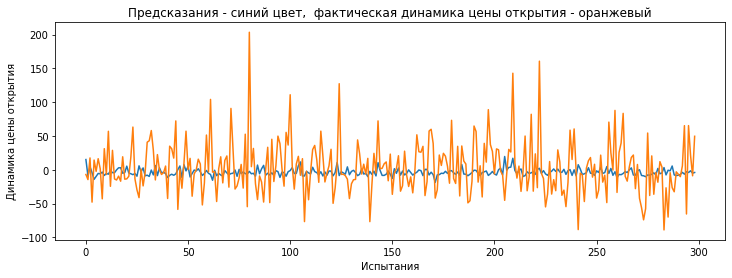

In [64]:
plt.figure(figsize=(12, 4))
plt.plot(denormalized_predictions)
plt.plot(denormalized_y_test)
plt.title("Предсказания - синий цвет,  фактическая динамика цены открытия - оранжевый")
plt.xlabel("Испытания")
plt.ylabel("Динамика цены открытия")
plt.show()

In [68]:
#создание списков для измерения, увеличилась или уменьшилась цена открытия
direction_pred = [1 if pred >= 0 else 0 for pred in denormalized_predictions]
direction_test = [1 if value >= 0 else 0 for value in denormalized_y_test]
direction = acc(direction_test, direction_pred)
direction = round(direction, 4) * 100
print("Прогнозируемые значения соответствуют фактическим в {}% случаев.".format(direction))

Прогнозируемые значения соответствуют фактическим в 48.83% случаев.
